In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)  # Unlimited columns

from sys import path
path.insert(0, '/Users/DMA/Repos/timeseries/src')
from custom_functions import see

In [175]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

# Forecasting pollution in Beijing
I'll be using the [Beijing PM2.5 Data Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data) from the UC Irvine data repository. This is an hourly data set of pollution (PM2.5 particles) from the US Embassy in Beijing, along with meteorological data from Beijing Capital International Airport. Data spans  Jan 1st, 2010 to Dec 31st, 2014.

Attribute Information:
```
No: row number 
year: year of data in this row 
month: month of data in this row 
day: day of data in this row 
hour: hour of data in this row 
pm2.5: PM2.5 concentration (ug/m^3) 
DEWP: Dew Point (â„ƒ) 
TEMP: Temperature (â„ƒ) 
PRES: Pressure (hPa) 
cbwd: Combined wind direction 
Iws: Cumulated wind speed (m/s) 
Is: Cumulated hours of snow 
Ir: Cumulated hours of rain 
```

In [306]:
df = pd.read_csv('../data/raw/PRSA_data_2010.1.1-2014.12.31.csv')

# Turns the several columns with time information into a single column
# with datetimes, and makes that the index.
df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.drop(columns=['No','year', 'month', 'day', 'hour'])

# Adds more evocative column names
df = df.rename(columns={
    'DEWP': 'dew_pt',
    'TEMP': 'temp',
    'PRES': 'pres',
    'cbwd': 'wind_dir',
    'Iws': 'wind_spd', 
    'Is': 'hours_snow', 
    'Ir': 'hours_rain' 
})

# Interpolates the missing values in pm2.5
# This takes care of the only nulls in the dataset
df['pm2.5'] = df['pm2.5'].interpolate(method='linear')

# ... except for the first 24 rows, that can't be interpolated
# because they're right at the beginning.  I'll delete them
df = df.dropna(subset=['pm2.5'])

We have 4 complete years of data.  I'll save the last month (December 2014) as a final test set, and use everything else for training.  I'll save the test set externally.

In [307]:
# Test is Dec 2014
test = df['2014-12'].copy()
test.to_csv('../data/processed/test.csv')

# the training set is everything until November 2014
train = df[:'2014-11'].copy()

For the rest of my model building, I'll use a handful of sequential train/test splits.  I don't want to predict more than a month into the future, but I do want to train on at least a year's data in order to capture annual seasonality.  So I'll do some explorations predicting an arbitrary month in the second year (April 2011) and later use other months within the training set.

In [323]:
# First train/validation set: Jan2010-Mar2011 and Apr2011
train1 = train[:'2011-3'].copy()
valid1 = train['2011-4'].copy()

train1.shape, valid1.shape

((10896, 8), (720, 8))

The pollution in this validation set has at least one 3-day stretch of missing data that was linearly interpolated and will affect our accuracy (around the second week).  These stretches are found throughout the dataset.

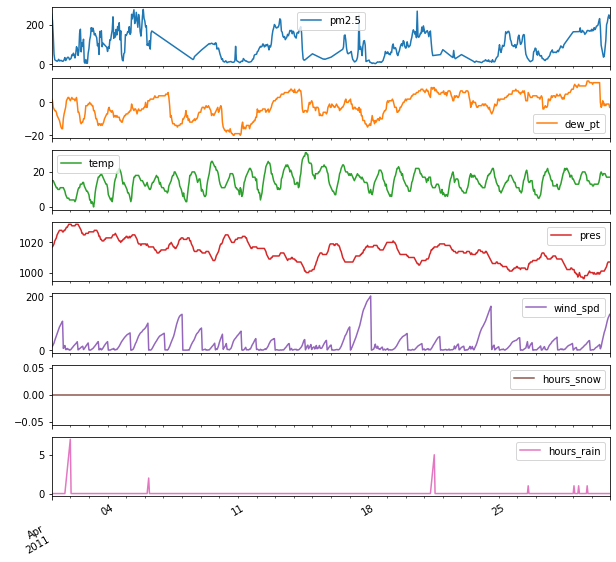

In [79]:
valid1.plot(subplots=True, figsize=(10,10));

Several features are heavily autocorrelated, as shown by these autocorrelation plots.

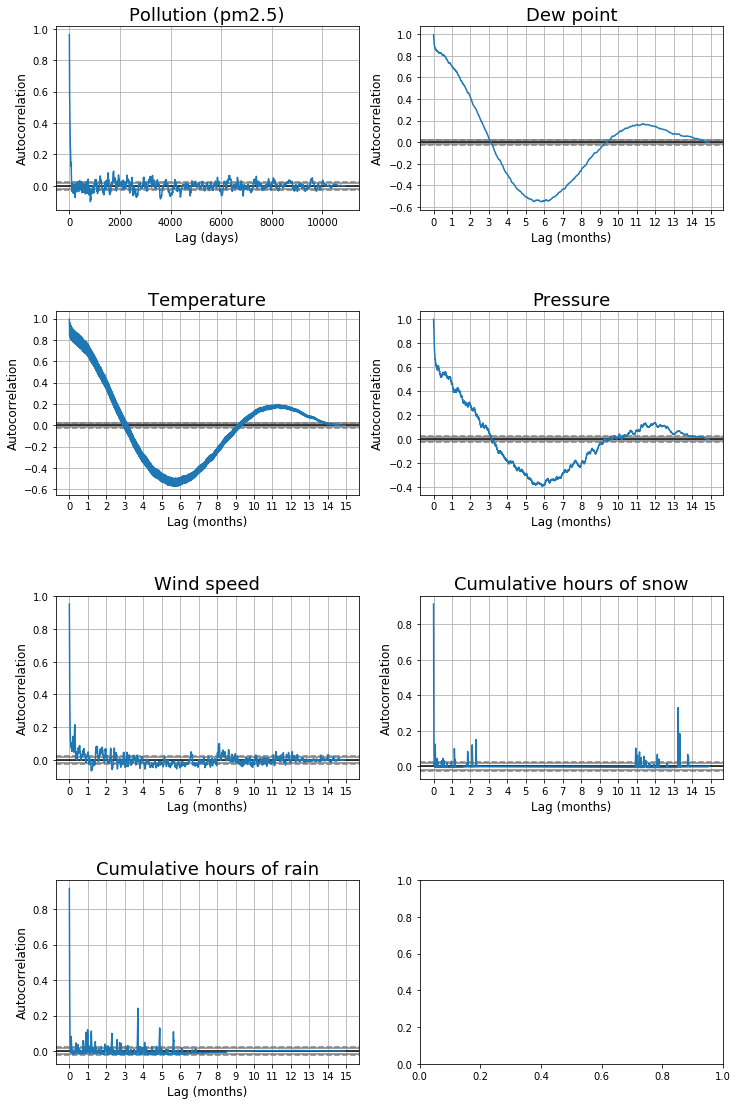

In [309]:
from pandas.plotting import autocorrelation_plot
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
num_cols = train1.select_dtypes(include='number').columns.tolist()

# Dictionary of descriptive feature names
feat_name_dict = {
        'pm2.5':'Pollution (pm2.5)',
        'dew_pt':'Dew point',
        'temp': 'Temperature',
        'pres': 'Pressure',
        'wind_dir':'Wind Direction',
        'wind_spd':'Wind speed',
        'hours_snow':'Cumulative hours of snow',
        'hours_rain':'Cumulative hours of rain'
                 }

fig, axes = plt.subplots(nrows=4, ncols=2, squeeze=True, figsize=(10,15))
fig.tight_layout(h_pad=8, w_pad=3)
axes = axes.reshape(-1)

# Plot an autocorrelation plot for each feature
for col, ax in zip(num_cols, axes):
    autocorrelation_plot(train1[col], ax=ax);
    ax.set_title(feat_name_dict[col], fontsize=18)
    ax.set_ylabel('Autocorrelation', fontsize=12)
    if col == 'pm2.5':
        ax.set_xlabel('Lag (days)', fontsize=12)
        continue
    ax.set_xlabel('Lag (months)', fontsize=12)
    tick_spacing = 730
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/730:.0f}'))


This autocorrelation chart doesn't show anything for pollution.  It displays a much shorter lag period (1 day) than the other charts, suggesting that it didn't find autocorrelation in the very near past and didn't search over longer lags.  The other features all show heavy autocorrelation with the last few hours, and temperature, pressure, and dew point show strong seasonal autocorrelation. Future feature engineering must include at least seasonal lag for those three features, and recent lag for all.

# Weather factor forecasting
I'll use Facebook's open source forecasting tool [Prophet](https://facebook.github.io/prophet/) to forecast each of my weather features separately a month into the future. The only information that I'll provide it about the future is a calendar of Chinese holidays.

In [162]:
from fbprophet import Prophet

Prophet requires its training data in the form of a dataframe with just two columns: `ds` (datestamp) and `y`. I'll write a couple of helper functions: one to shape the inputs and feed them to Prophet, and another to plot the results.

In [408]:
def prophesize(train, valid):
    """
    Fit Prophet to training data, produce forecasts
    
    Parameters
    ----------
    train: pd.DataFrame of training data, with a datetime index 
            and only one column (y)
    valid: pd.DataFrame of validation data, with a datetime index.
            must have timepoints that follow after 'train'.
    floor: Can be either False or a number.  If a number, set that as
            the floor for predictions.
    
    Returns
    -------
    m: a trained Prophet model
    
    forecast: A forecast over the time in 'valid'
    
    future: a dataset with timestamps for the predictions
    """
    
    # Turns the datetime index into its own column, 'ds'
    train = train.copy().reset_index()
    train.columns = ['ds', 'y']
    
    # Instantiates and fits
    m = Prophet(yearly_seasonality=True)
    m.add_country_holidays('CN') # adds Chinese holidays
    m.fit(train)
    
    # Makes a dataframe of future hourly predictions that extends throughout 
    # the length of the validation period. (Assumes hourly sampling)
    future = m.make_future_dataframe(periods=len(valid), freq='H',
                                     include_history=False)
    
    # Makes a forecast for the times listed in 'future'.
    forecast = m.predict(future)
    
    return m, forecast, future

In [287]:
def plot_prophecies(m, forecast, train, valid):
    """
    Parameters
    ----------
    train: pd.DataFrame of training data, with a datetime index 
            and only one column (y)
            
    valid: pd.DataFrame of validation data, with a datetime index.
            must have timepoints that follow after 'train'.
    
    m: a Prophet model trained on 'train'
    
    forecast: the forecast from m, made for 'valid'
    
    
    Returns
    -------
    fig: A matplotlib figure
    
    """
    # Change the index in the forecast equal to the datetime column
    forecast = forecast.set_index('ds', drop=False)
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    # Plot historical data points in blue
    ax.scatter(x=train.index.tolist(),
               y=train,
               marker='.', c='blue')
    
    # Plot forecast trend in solid orange
    ax.plot(forecast['yhat'], ls='-', c='orange')
    
    # Plot forecast confidence interval as space-filling orange
    ax.fill_between(x=valid.index.tolist(), 
                    y1=forecast['yhat_lower'], 
                    y2=forecast['yhat_upper'],
                    color='orange', 
                    alpha=0.2)
    
    # Plot validation points in red
    ax.scatter(x=valid.index.tolist(),
               y=valid, marker='.', c='orangered')
    
    return fig

In [263]:
%%time
m, forecast, _ = prophesize(train1['temp'], valid1['temp'])

CPU times: user 17.6 s, sys: 1.07 s, total: 18.6 s
Wall time: 13.9 s


In [264]:
see(forecast)

shape: (720, 46)



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labor Day,Labor Day_lower,Labor Day_upper,Mid-Autumn Festival,Mid-Autumn Festival_lower,Mid-Autumn Festival_upper,National Day,National Day_lower,National Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Tomb-Sweeping Day,Tomb-Sweeping Day_lower,Tomb-Sweeping Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-04-01 00:00:00,14.465174,4.993682,13.636788,14.465174,14.465174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.962899,-4.962899,-4.962899,-2.281025,-2.281025,-2.281025,0.0,0.0,0.0,0.099302,0.099302,0.099302,-2.781176,-2.781176,-2.781176,0.0,0.0,0.0,9.502275
1,2011-04-01 01:00:00,14.465732,4.588006,12.844637,14.465732,14.465732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.468458,-5.468458,-5.468458,-2.800079,-2.800079,-2.800079,0.0,0.0,0.0,0.099507,0.099507,0.099507,-2.767886,-2.767886,-2.767886,0.0,0.0,0.0,8.997274
2,2011-04-01 02:00:00,14.466290,4.656063,13.001398,14.466290,14.466290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.838834,-5.838834,-5.838834,-3.182642,-3.182642,-3.182642,0.0,0.0,0.0,0.098424,0.098424,0.098424,-2.754616,-2.754616,-2.754616,0.0,0.0,0.0,8.627456


Let's look at just the predictions (April) and the last half-month of training, and compare Prophet's predictions to the validation data

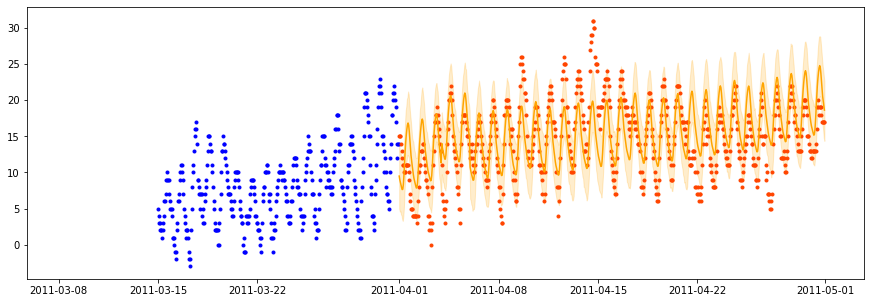

In [288]:
plot_prophecies(m, forecast, 
                train = train1['temp']['2011-03-15':'2011-03-31'], 
                valid = valid1['temp']);

Prophet shows us the complete training+validation dataset, and the decomposition of the factors that went into the prediction.

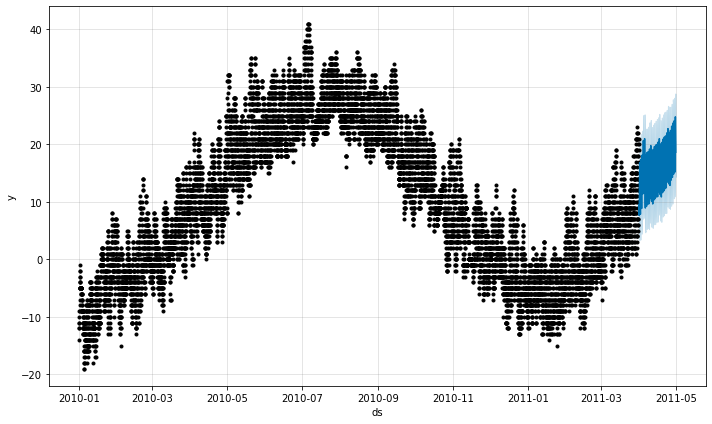

In [265]:
m.plot(forecast);

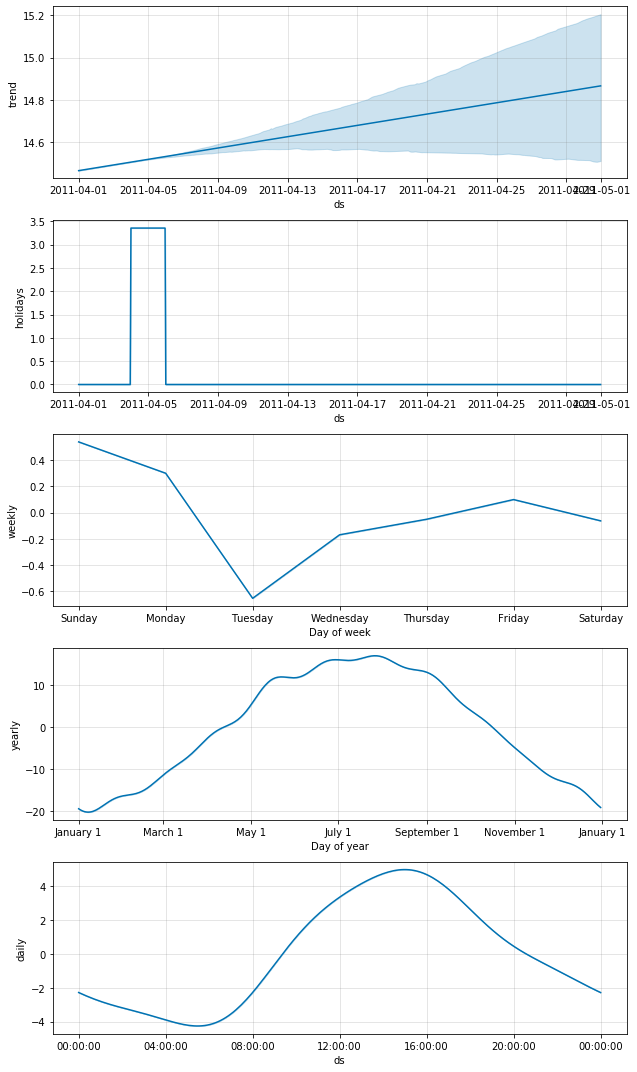

In [266]:
m.plot_components(forecast);

# Prophet + tabular fast.ai
I'll use Prophet to estimate all the weather factors for a particular month. I'll then train a neural network on the whole dataset, ignaring time, to predict pollution based on the factors.  I'll use that to generate pollution predictions. The first step is to write a script that will create predictions for all the factors we care about. 

### Remove categoricals
At first I tried to one-hot encode our one categorical variable (wind speed direction), but it soon became clear that Prophet can't handle categorical predictions. This graph shows it trying to predict one of the one-hot-encoded options, and producing floating point predictions.  I'll remove wind speed direction from our analysis for now.

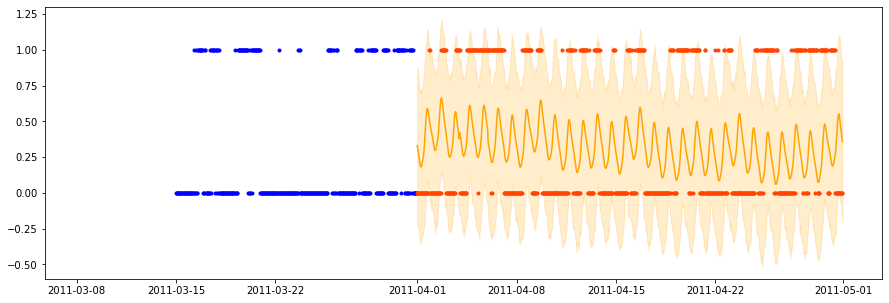

In [343]:
from category_encoders.one_hot import OneHotEncoder
ohe = OneHotEncoder()
train1 = ohe.fit_transform(train1)
valid1 = ohe.transform(valid1)

m, forecast, _ = prophesize(train1['wind_dir_1'], valid1['wind_dir_1'])

plot_prophecies(m=m, 
                forecast=forecast, 
                train = train1['wind_dir_1']['2011-03-15':'2011-03-31'], 
                valid = valid1['wind_dir_1']);

In [361]:
# Resets the train/valid datasets to what they were before OH encoding,
# Minus the categorical feature
train1 = train[:'2011-3'].drop(columns=['wind_dir'])
valid1 = train['2011-4'].drop(columns=['wind_dir'])

### Make all predictions
This custom function runs a single Prophet forecast for each weather feature, then bundles the results together.

In [409]:
def prophesize_all(train, valid):
    """
        Parameters
    ----------
    train: pd.DataFrame of training data, with a datetime index 
            and only one column (y)
            
    valid: pd.DataFrame of validation data, with a datetime index.
            must have timepoints that follow after 'train'.
        
    Returns
    -------
    future: A pd.DataFrame with all the forecasts, for the times in 'valid'
    
    models: A dictionary of the trained models for each feature
    
    forecasts: A dictionary of forecasts for each feature
    """
    columns = train.columns.tolist()
    
    models = {}
    forecasts = {}
    
    # Run one cycle to get a 'future' dataframe
    col = columns[0]
    print(f'Predicting {col}')
    m, forecast, future = prophesize(train[col], valid[col])
    future['obs_pm2.5'] = valid['pm2.5'].values # Populate with validation data
    future[col] = forecast['yhat']
    models[col] = m
    forecasts[col] = forecast
    
    for col in columns[1:]:
        print(f'Predicting {col}')
        m, forecast, _ = prophesize(train[col], valid[col])
        future[col] = forecast['yhat']
        models[col] = m
        forecasts[col] = forecast
        
    return future, models, forecasts

In [413]:
%%time
future, models, forecasts = prophesize_all(train1, valid1)

Predicting pm2.5
Predicting dew_pt
Predicting temp
Predicting pres
Predicting wind_spd
Predicting hours_snow
Predicting hours_rain
CPU times: user 2min 40s, sys: 5.81 s, total: 2min 46s
Wall time: 2min 12s


In [414]:
future

,ds,obs_pm2.5,pm2.5,dew_pt,temp,pres,wind_spd,hours_snow,hours_rain
0,2011-04-01 00:00:00,254.5,101.111801,-7.388946,9.641883,1024.771955,34.913094,-0.148314,0.158697
1,2011-04-01 01:00:00,222.0,100.590116,-7.399613,9.141032,1024.729322,33.681093,-0.149517,0.190746
2,2011-04-01 02:00:00,147.0,98.989227,-7.455265,8.772867,1024.652757,32.355329,-0.146800,0.215814
3,2011-04-01 03:00:00,51.0,95.732335,-7.557913,8.442708,1024.573984,30.936717,-0.144271,0.228209
4,2011-04-01 04:00:00,23.0,91.052431,-7.662075,8.075772,1024.542609,29.447451,-0.146767,0.231952
...,...,...,...,...,...,...,...,...,...
715,2011-04-30 19:00:00,201.0,37.355590,-0.775742,21.906068,1027.509164,65.559096,0.155765,0.019741
716,2011-04-30 20:00:00,214.0,44.099475,-0.412088,20.982317,1027.984603,64.635822,0.156863,0.021847
717,2011-04-30 21:00:00,238.0,49.416196,-0.155684,20.281934,1028.385831,63.843364,0.163968,0.010473
718,2011-04-30 22:00:00,251.0,52.375255,-0.012311,19.671610,1028.640817,63.248073,0.176235,-0.006188


Pollution (pm2.5)


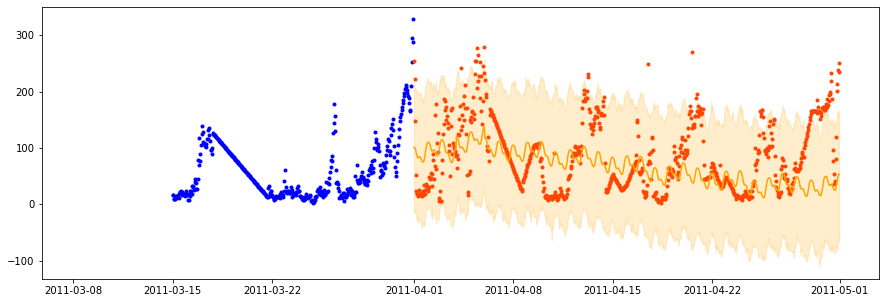

Dew point


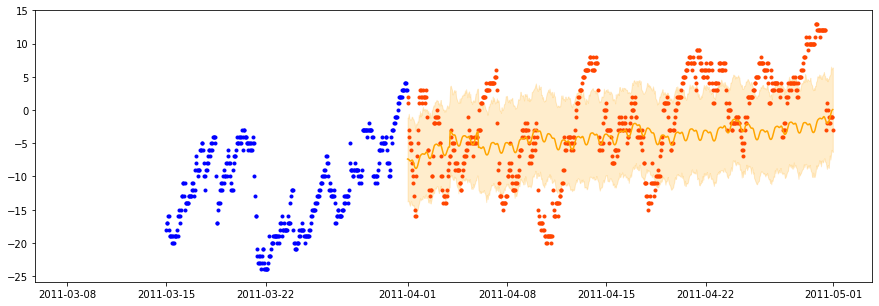

Temperature


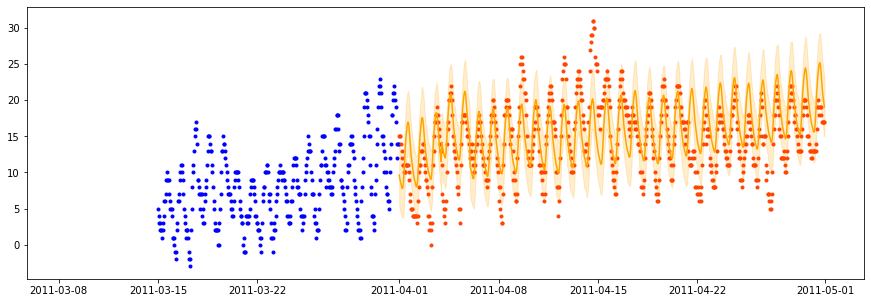

Pressure


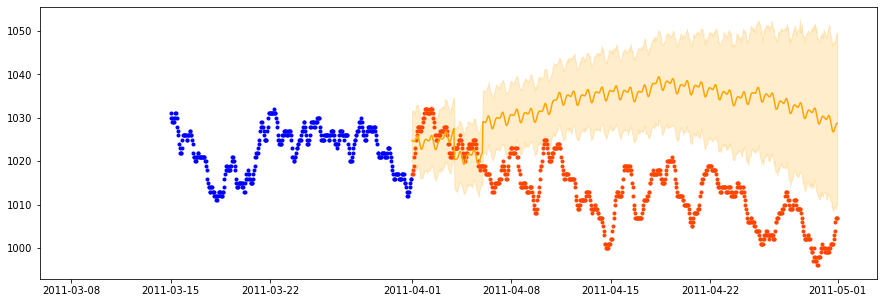

Wind speed


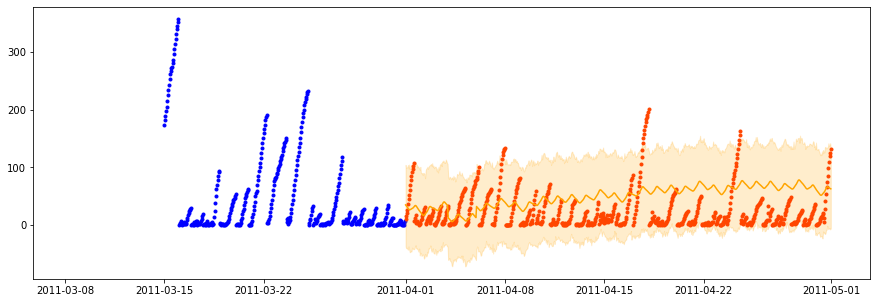

Cumulative hours of snow


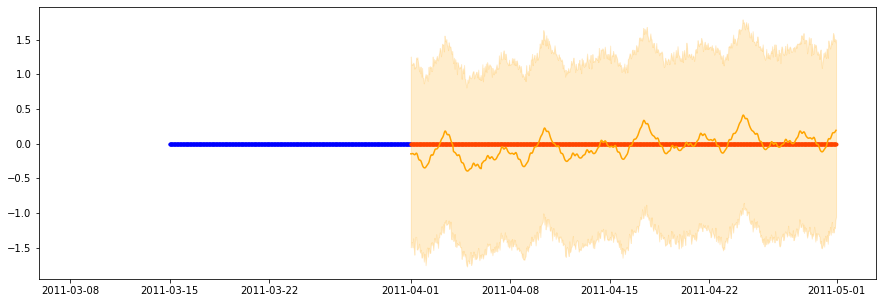

Cumulative hours of rain


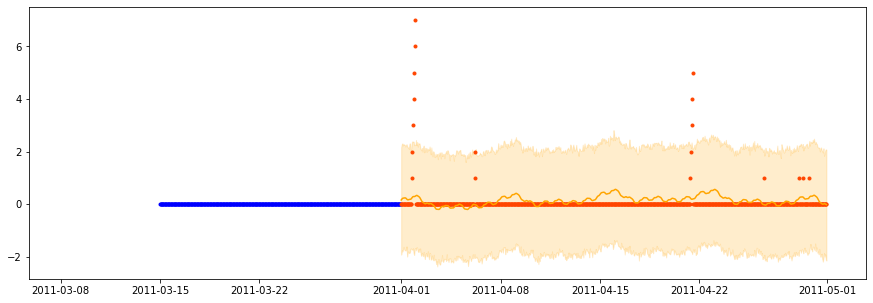

In [415]:
columns = train1.columns.tolist()
for col, ax in zip(columns, axes):
    m = models[col]
    forecast = forecasts[col]
    f = plot_prophecies(m=m, 
                    forecast=forecast, 
                    train = train1[col]['2011-03-15':'2011-03-31'], 
                    valid = valid1[col]);
    print(feat_name_dict[col])
    plt.show()

As you can see, predictions are much more effective for heavily predictable things like temperature, and pretty useless for most others more than about one week into the future.  We'll see how well this serves as an input for a neural network in the next section.

In [416]:
# Pickle away the results
import pickle
cache = (future, models, forecasts)
pickle.dump( cache, open( "../models/forecasts1.pkl", "wb" ))

In [424]:
# Un-pickle them back
future, models, forecasts = pickle.load(open( "../models/forecasts1.pkl", "rb" ))

### Tabular Deep Learner
I'll use the training data and our new predictions for the validation month to create the input for a tabular network.  I'll use the fast.ai library to add some features related to the date, and I'll also add a column that explicitly states whether it's a holiday or not.

In [447]:
from fastai.tabular import *

In [458]:
def dl_data_prep(train, valid):
    """
    Prepares data for a fast.ai tabular DL model.
    
    Parameters
    ----------
    train: pd.DataFrame of training data, with a datetime index 
            and only one column (y)
            
    valid: pd.DataFrame of validation data, with a datetime index.
            must have timepoints that follow after 'train'.
        
    Returns
    -------

    """
    # Rename stuff.  
    # We'll create a new validation set from the last 30 days of
    # training data, and use 'valid' as the test set
    test = valid.copy()
    valid = train[-(30*24):].copy()
    train = train[:-(30*24)].copy()
    
    
    def add_dates(df):
        """
        Treatments for all the internal datasets
        """
        df = df.reset_index(drop=False)
        add_datepart(df, 'index', prefix='', time=True)
        df = df.drop(columns=['Minute','Second'])
        
        return df
        
    train = add_dates(train)
    valid = add_dates(valid)
    test = add_dates(test)
    
    return train, valid, test
    
train, valid, test = dl_data_prep(train1, valid1)
valid

,pm2.5,dew_pt,temp,pres,wind_spd,hours_snow,hours_rain,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Elapsed
0,9.000000,-18,1.0,1026.0,115.78,0,0,2011,3,9,2,2,61,False,False,False,False,False,False,0,1299024000
1,11.000000,-16,-1.0,1026.0,121.59,0,0,2011,3,9,2,2,61,False,False,False,False,False,False,1,1299027600
2,14.000000,-16,-2.0,1026.0,124.72,0,0,2011,3,9,2,2,61,False,False,False,False,False,False,2,1299031200
3,11.000000,-16,-4.0,1026.0,3.13,0,0,2011,3,9,2,2,61,False,False,False,False,False,False,3,1299034800
4,12.000000,-16,-3.0,1026.0,0.89,0,0,2011,3,9,2,2,61,False,False,False,False,False,False,4,1299038400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,210.333333,4,17.0,1013.0,1.78,0,0,2011,3,13,31,3,90,True,False,True,False,False,False,19,1301598000
716,252.666667,4,14.0,1014.0,0.89,0,0,2011,3,13,31,3,90,True,False,True,False,False,False,20,1301601600
717,295.000000,4,12.0,1015.0,0.89,0,0,2011,3,13,31,3,90,True,False,True,False,False,False,21,1301605200
718,328.000000,3,14.0,1016.0,3.13,0,0,2011,3,13,31,3,90,True,False,True,False,False,False,22,1301608800


In [ ]:
# First normalize, then add date parts